<a href="https://colab.research.google.com/github/rahulin05/EIP-4/blob/master/Week-5/Asssignment_5_EIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import os
os.listdir(".")

['.config', 'gdrive', 'sample_data']

In [4]:
!unzip -q "/content/gdrive/My Drive/hvc_data.zip"
# look for `hvc_annotations.csv` file and `resized` dir
%ls

gdrive/  hvc_annotations.csv  resized/  sample_data/


In [0]:
!pip install --upgrade --upgrade-strategy only-if-needed https://github.com/faizanahemad/data-science-utils/tarball/master > /dev/null

In [6]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git


  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-c_8qbdmk
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-c_8qbdmk
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-cp36-none-any.whl size=101065 sha256=95a04d713709a9cd66f1d5eb44b8a0de9cdc6c9523c6b1f28a12391218846cfd
  Stored in directory: /tmp/pip-ephem-wheel-cache-2_hnrhms/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [7]:
import cv2
import json
import tensorflow as tf
import os
import shutil

import numpy as np
import pandas as pd

from functools import partial
from pathlib import Path 
from tqdm import tqdm
from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import keras
from keras import backend as K
from keras.applications import VGG16
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input, Conv2D, MaxPool2D
from keras.layers import AveragePooling2D, Input, Flatten, Activation, Flatten, Dropout, SeparableConv2D, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

from keras.regularizers import l2


from albumentations import (
    Compose, HorizontalFlip, ToFloat, ShiftScaleRotate,
    Normalize, Rotate, Cutout
)

Using TensorFlow backend.


In [8]:
# load annotations
df = pd.read_csv("hvc_annotations.csv")
del df["filename"] # remove unwanted column
df.head()

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg


In [9]:
print(df.groupby("gender")["gender"].count())
print("Baseline gender accuracy: "+str(max(df.groupby("gender")["gender"].count())/sum(df.groupby("gender")["gender"].count())))
print("\n")

print(df.groupby("imagequality")["imagequality"].count())
print("Baseline imagequality accuracy: "+str(max(df.groupby("imagequality")["imagequality"].count())/sum(df.groupby("imagequality")["imagequality"].count())))
print("\n")

print(df.groupby("age")["age"].count())
print("Baseline age accuracy: "+str(max(df.groupby("age")["age"].count())/sum(df.groupby("age")["age"].count())))
print("\n")

print(df.groupby("weight")["weight"].count())
print("Baseline weight accuracy: "+str(max(df.groupby("weight")["weight"].count())/sum(df.groupby("weight")["weight"].count())))
print("\n")

print(df.groupby("carryingbag")["carryingbag"].count())
print("Baseline carryingbag accuracy: "+str(max(df.groupby("carryingbag")["carryingbag"].count())/sum(df.groupby("carryingbag")["carryingbag"].count())))
print("\n")

print(df.groupby("footwear")["footwear"].count())
print("Baseline footwear accuracy: "+str(max(df.groupby("footwear")["footwear"].count())/sum(df.groupby("footwear")["footwear"].count())))
print("\n")

print(df.groupby("emotion")["emotion"].count())
print("Baseline emotion accuracy: "+str(max(df.groupby("emotion")["emotion"].count())/sum(df.groupby("emotion")["emotion"].count())))
print("\n")

print(df.groupby("bodypose")["bodypose"].count())
print("Baseline bodypose accuracy: "+str(max(df.groupby("bodypose")["bodypose"].count())/sum(df.groupby("bodypose")["bodypose"].count())))
print("\n")

gender
female    5937
male      7636
Name: gender, dtype: int64
Baseline gender accuracy: 0.5625874898695941


imagequality
Average    7509
Bad        2240
Good       3824
Name: imagequality, dtype: int64
Baseline imagequality accuracy: 0.5532306785530097


age
15-25    2494
25-35    5411
35-45    3435
45-55    1490
55+       743
Name: age, dtype: int64
Baseline age accuracy: 0.39865910263022175


weight
normal-healthy         8628
over-weight             891
slightly-overweight    3196
underweight             858
Name: weight, dtype: int64
Baseline weight accuracy: 0.6356737640904737


carryingbag
Daily/Office/Work Bag       4603
Grocery/Home/Plastic Bag    1321
None                        7649
Name: carryingbag, dtype: int64
Baseline carryingbag accuracy: 0.56354527370515


footwear
CantSee    5028
Fancy      2507
Normal     6038
Name: footwear, dtype: int64
Baseline footwear accuracy: 0.4448537537758786


emotion
Angry/Serious    1500
Happy            1609
Neutral          9660
Sad 

In [0]:
# one hot encoding of labels

one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose")
    ], axis = 1)

In [0]:
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

In [0]:
class PersonImageDataGenerator(keras.utils.Sequence):

  def __init__(self, data_df, image_size=(224, 224, 3), batch_size=32, shuffle=True, augment=None):
    self.data_df = data_df
    self.indices = data_df.index.tolist()
    self.output_size = image_size
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.augment = augment
    self.on_epoch_end()

  def __len__(self):
    # return number of batches (truncated)
    return int(np.floor(len(self.data_df)/self.batch_size))

  def __getitem__(self, idx):
    batch_df = self.data_df.iloc[idx*self.batch_size:(idx+1)*self.batch_size, :].copy()
    indices = batch_df.index.tolist()
    images = np.stack([cv2.resize(cv2.imread(batch_df.loc[rownum, "image_path"]), (self.output_size[0], self.output_size[1])) for rownum in indices])
    _gender_cols_ = [col for col in batch_df.columns if col.startswith("gender")]
    target = {
            "gender_output": batch_df[_gender_cols_].values,
            "image_quality_output": batch_df[_imagequality_cols_].values,
            "age_output": batch_df[_age_cols_].values,
            "weight_output": batch_df[_weight_cols_].values,
            "bag_output": batch_df[_carryingbag_cols_].values,
            "pose_output": batch_df[_bodypose_cols_].values,
            "footwear_output": batch_df[_footwear_cols_].values,
            "emotion_output": batch_df[_emotion_cols_].values
        }
    if self.augment==None:
      return images, target
    else:
      return np.stack([self.augment(image=x)["image"] for x in images], axis=0), target

  def on_epoch_end(self):
    # shuffle dataset at the end of every epoch
    if self.shuffle==True:
      self.data_df = self.data_df.sample(frac=1).reset_index(drop=True)
    else:
      self.data_df = self.data_df.reset_index(drop=True)

In [0]:
# callbacks

class CyclicLR(keras.callbacks.Callback):
    
    def __init__(self,base_lr, max_lr, step_size, base_m, max_m, cyclical_momentum):
 
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.base_m = base_m
        self.max_m = max_m
        self.cyclical_momentum = cyclical_momentum
        self.step_size = step_size
        
        self.clr_iterations = 0.
        self.cm_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}
        # self.on_epoch_end()
        
    def clr(self):
        
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        
        if cycle == 2:
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)          
            return self.base_lr-(self.base_lr-self.base_lr/100)*np.maximum(0,(1-x))
        
        else:
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0,(1-x))
    
    def cm(self):
        
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        
        if cycle == 2:
            
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1) 
            return self.max_m
        
        else:
            x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
            return self.max_m - (self.max_m-self.base_m)*np.maximum(0,(1-x))
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())
            
        if self.cyclical_momentum == True:
            if self.clr_iterations == 0:
                K.set_value(self.model.optimizer.momentum, self.cm())
            else:
                K.set_value(self.model.optimizer.momentum, self.cm())
            

    def on_batch_begin(self, batch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)
        
        if self.cyclical_momentum == True:
            self.history.setdefault('momentum', []).append(K.get_value(self.model.optimizer.momentum))

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())
        
        if self.cyclical_momentum == True:
            K.set_value(self.model.optimizer.momentum, self.cm())


# print LR
class printLR(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        print(K.eval(lr))
        

In [0]:

def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))
    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [16]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.15, random_state=42)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
train_df.shape, val_df.shape

((11537, 28), (2036, 28))

In [0]:
train_images = [cv2.imread(train_df["image_path"].iloc[x]) for x in range(len(train_df))]
train_images = np.stack(train_images)
labels = train_df[_gender_cols_].values

In [18]:
train_images.shape

(11537, 224, 224, 3)

In [19]:
labels.shape

(11537, 2)

In [0]:
# train_mean = np.mean(train_images, axis=(0, 1, 2))/255.0
train_mean = np.array([0.16198463, 0.1628683 , 0.18274376])
# train_std = np.std(train_images, axis=(0, 1, 2))/255.0
train_std = np.array([0.25078711, 0.25332862, 0.27367283])

In [0]:
# Training parameters
n = 2 #(number of resnet blocks)
depth = n*9+2

# Input image dimensions.
input_shape = (224, 224, 3)

In [23]:
"""ResNet v20

Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
bottleneck layer
First shortcut connection per layer is 1 x 1 Conv2D.
Second and onwards shortcut connection is identity.
At the beginning of each stage, the feature map size is halved (downsampled)
by a convolutional layer with strides=2, while the number of filter maps is
doubled. Within each stage, the layers have the same number filters and the
same filter map sizes.
Features maps sizes:
224x224x3
conv - 222x222
maxpool - 111x111
reslayer - 111x111
Stage 0 - 111x111x64
Stage 1 - 56x56x128
Stage 3 - 28x28x256
1d conv - 28x28x128
maxpool - 14x14x128
separable conv2d - 12x12x160
separable conv2d - 10x10x192
conv2d - 8x8x208
conv2d - 6x6x224
conv2d - 4x4x240

"""
# Start model definition.
num_filters_in = 16
num_res_blocks = n

inputs = Input(shape=input_shape)   # size 224x224

# x = MaxPool2D(pool_size=(2,2))(inputs)   # output 112x112

x = Conv2D(16,
          kernel_size=(3,3),
          kernel_initializer='he_normal',
          kernel_regularizer=l2(1e-4),
          activation='relu')(inputs)  # output 110x110
                                 # output 222x222
x = MaxPool2D(pool_size=(2,2))(x)   # output 55x55
                                    # output 111x111


# v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
x = resnet_layer(inputs=x,
                num_filters=num_filters_in,
                conv_first=True)  # output of 54x54
                                  # output 111x111
# 3 stages - each stage has n residual blocks (each residual block has 3 convolution sets, the first one compresses except in the first stage)
# Instantiate the stack of residual units
for stage in range(3):
    for res_block in range(num_res_blocks):
        activation = 'relu'
        batch_normalization = True
        strides = 1
        if stage == 0:
            num_filters_out = num_filters_in * 4
            if res_block == 0:  # first layer and first stage
                activation = None
                batch_normalization = False
        else:
            num_filters_out = num_filters_in * 2
            if res_block == 0:  # first layer but not first stage
                strides = 2    # downsample
        # bottleneck residual unit
        y = resnet_layer(inputs=x,
                          num_filters=num_filters_in,
                          kernel_size=1,
                          strides=strides,
                          activation=activation,
                          batch_normalization=batch_normalization,
                          conv_first=False)
        # y = Dropout(0.2)(y)
        y = resnet_layer(inputs=y,
                          num_filters=num_filters_in,
                          conv_first=False)
        y = resnet_layer(inputs=y,
                          num_filters=num_filters_out,
                          kernel_size=1,
                          conv_first=False)
        # y = Dropout(0.2)(y)

        if res_block == 0:
            # linear projection residual shortcut connection to match
            # changed dims
            x = resnet_layer(inputs=x,
                              num_filters=num_filters_out,
                              kernel_size=1,
                              strides=strides,
                              activation=None,
                              batch_normalization=False)
            x = keras.layers.add([x, y])

    num_filters_in = num_filters_out
# output from resnet layers of 14x14
                              #  28x28
x = Conv2D(128,
           kernel_size=1)(x) # output of 14x14
                                        #  28x28
x = Dropout(0.2)(x)

x = MaxPool2D(pool_size=(2,2))(x)  # output of 7x7
                                   #  14x14

x = SeparableConv2D(filters = 160, kernel_size=3, activation = 'relu')(x) #12x12

x = SeparableConv2D(filters = 192, kernel_size=3, activation = 'relu')(x) #10x10

x = Conv2D(208,
           kernel_size=(3,3), activation='relu')(x)   # output of 8x8
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Conv2D(224,
           kernel_size=(3,3), activation='relu')(x)   # output of 6x6
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Conv2D(240,
           kernel_size=(3,3), activation='relu')(x)   # output of 4x4
x = BatchNormalization()(x)

x = GlobalAveragePooling2D()(x)

output = Dense(2, activation="softmax", name="gender_output")(x)


# define model
model = Model(
    inputs=inputs, 
    outputs=output
)

opt = SGD(lr=0.0005, momentum=0.9, nesterov=True)
model.compile(
    optimizer=opt,
    loss="categorical_crossentropy", 
    # loss_weights=loss_weights, 
    metrics=["accuracy"]
)

model.summary()















Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 222, 222, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 111, 111, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 111, 111, 16) 2320    

In [0]:
from keras.models import load_model
model = load_model("/content/gdrive/My Drive/eip4_assignment5_modelweights/29dec_earlystart/eip4a5_model_res20.037.h5")
model.summary()

In [0]:
# set up training parameters
training_batch_size=32
epochs=30


AUGMENTATIONS_TRAIN = Compose([
    HorizontalFlip(p=0.5),
    # Cutout(num_holes=1, max_h_size = int(input_shape[0]/5), max_w_size=int(input_shape[0]/5), p=1),
    # Normalize(mean=tuple(train_mean), std=tuple(train_std), max_pixel_value=255.0, p=1),
    Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1),
    ShiftScaleRotate(
        shift_limit=0.0625, scale_limit=0.1, 
        rotate_limit=15, border_mode=cv2.BORDER_REFLECT_101, p=0.3)
])

AUGMENTATIONS_VAL = Compose([
    # CLAHE(p=1.0, clip_limit=2.0),
    # Normalize(mean=tuple(train_mean), std=tuple(train_std), max_pixel_value=255.0, p=1.0)
    # , 
    Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255.0, p=1)
])

In [26]:
# create train and validation data generators
train_genr = PersonImageDataGenerator(train_df, batch_size=training_batch_size, shuffle=True, augment=AUGMENTATIONS_TRAIN)
valid_genr = PersonImageDataGenerator(val_df, batch_size=64, shuffle=False, augment=AUGMENTATIONS_VAL)
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}

NameError: ignored

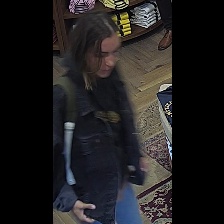

['gender_female', 'gender_male']
[1 0]
['imagequality_Average', 'imagequality_Bad', 'imagequality_Good']
[1 0 0]
['age_15-25', 'age_25-35', 'age_35-45', 'age_45-55', 'age_55+']
[0 1 0 0 0]
['weight_normal-healthy', 'weight_over-weight', 'weight_slightly-overweight', 'weight_underweight']
[1 0 0 0]
['carryingbag_Daily/Office/Work Bag', 'carryingbag_Grocery/Home/Plastic Bag', 'carryingbag_None']
[1 0 0]
['footwear_CantSee', 'footwear_Fancy', 'footwear_Normal']
[1 0 0]
['emotion_Angry/Serious', 'emotion_Happy', 'emotion_Neutral', 'emotion_Sad']
[1 0 0 0]
['bodypose_Back', 'bodypose_Front-Frontish', 'bodypose_Side']
[0 1 0]


In [29]:
# get number of output units from data
images, targets = next(iter(train_genr))
i=9
cv2_imshow(images[i]*255)
print(_gender_cols_)
print(targets["gender_output"][i])
print(_imagequality_cols_)
print(targets["image_quality_output"][i])
print(_age_cols_)
print(targets["age_output"][i])
print(_weight_cols_)
print(targets["weight_output"][i])
print(_carryingbag_cols_)
print(targets["bag_output"][i])
print(_footwear_cols_)
print(targets["footwear_output"][i])
print(_emotion_cols_)
print(targets["emotion_output"][i])
print(_bodypose_cols_)
print(targets["pose_output"][i])

In [0]:
import keras_contrib
from data_science_utils.vision.keras import LRFinder

In [0]:
lrf = LRFinder(model)
lrf.find_generator(train_genr, 0.0000001, 10, valid_genr, epochs=4)
lrf.plot_loss()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


